# 第7回 特徴量エンジニアリング

今回は様々なデータセットを題材として特徴量エンジニアリングについて学びます。

ゴール：特徴量エンジニアリングの手法を学び、適切に使い分けられるようになる。

## 目次
**[1 はじめに](#1-はじめに)**
> [1.1 準備](#1.1-準備)<br>
> [1.2 特徴量エンジニアリング概要](#1.2-特徴量エンジニアリング概要)

**[2 数値変数の変換](#2-数値変数の変換)**
> [2.1 スケーリング](#2.1-スケーリング)<br>
> [2.2 非線形変換](#2.2-非線形変換)<br>
> [2.3 交差項の作成](#2.3-交差項の作成)

**[3 カテゴリ変数のエンコーディング](#3-カテゴリ変数のエンコーディング)**
> [3.1 Label Encoding](#3.1-Label-Encoding)<br>
> [3.2 Count Encoding](#3.2-Count-Encoding)<br>
> [3.3 Label-Count Encoding](#3.3-Label-Count-Encoding)<br>
> [3.4 One-Hot Encoding](#3.4-One-Hot-Encoding)<br>
> [3.5 特徴量作成例](#3.5-特徴量作成例)

**[4 時間変数のエンコーディング](#4-時間変数のエンコーディング)**

> [4.0 時系列データとは](#4.0-時系列データとは)<br>
> [4.1 時系列データの取り扱い](#4.1-時系列データの取り扱い)<br>
> [4.2 周期性を考慮しないエンコーディング](#4.2-周期性を考慮しないエンコーディング)<br>
> [4.3 周期性を考慮したエンコーディング](#4.3-周期性を考慮したエンコーディング)

**[5 次元削減と特徴選択](#5-次元削減と特徴選択)**
> [5.1 次元削減](#5.1-次元削減)<br>
> [5.2 特徴選択](#5.2-特徴選択)

## 1 はじめに

### 1.1 準備
まず基本的なライブラリの読み込みや、設定を済ませておきます。

In [ ]:
# ライブラリの読み込み
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
%matplotlib inline

# その他設定
import warnings
warnings.filterwarnings('ignore')

### 1.2 特徴量エンジニアリング概要
特徴量エンジニアリングとは、モデルの学習・予測に効果的な説明変数を作成しようとする試みです。
（説明変数と特徴量はほぼ同義ですが、前者は統計学・後者は機械学習分野での用語となっています。）

特徴量エンジニアリングの取り組みには、大別して二つの方向性があります;
- 問題設定に依らない汎用的な手法を用いるもの
- 問題設定に特有の背景知識に基づくもの

今回は、汎用的な前者の手法の中から、代表的なものをいくつか紹介します。

初めに、数値変数とカテゴリカル変数の違いについて確認しておきましょう。
データの型には、大別して数値変数とカテゴリカル変数の二つがあります;
- 数値変数: 比例尺度・間隔尺度
- カテゴリカル変数: 順序尺度・名義尺度

ほぼ全ての機械学習モデルの実装は、カテゴリカル変数を含むデータに対して学習や予測ができません。
そのため、カテゴリカル変数は予め数値変数に変換しておく必要があります。（エンコーディング）

## 2 数値変数の変換

### 2.1 スケーリング
数値変数間のスケールが異なる場合、非決定木系のモデルでは適切に学習が行われないことがあります。
そのような場合には、標準化や正規化と呼ばれる変換によって、数値変数に対しスケーリングを施します。

- 標準化:
　平均が0・標準偏差が1になるよう以下のように変換します。
　ただし $\mu_x$ と $\sigma_x$ はそれぞれ $x$ の平均と標準偏差です。
\begin{equation}
x_{std} = \cfrac{x - \mu_x}{\sigma_x}
\end{equation}

- 正規化:
　最小値が0・最大値が1になるよう以下のように変換します。
\begin{equation}
x_{norm} = \cfrac{x - x_{min}}{x_{max} - x_{min}}
\end{equation}

ここではアヤメデータセットを用いて、前者の標準化の適用方法とその使い分けについて見てみましょう。
標準化は上の式に従って簡単に実装できますが、以下のように実装済みのものを利用することもできます。
以下では、`sepal length (cm)` を sklearn.preprocessing.StandardScaler により標準化しています。

In [ ]:
# ライブラリの読み込み
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

# データの読み込み
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target

# 対象変数の取り出し
x = df[['sepal length (cm)']]

# 標準化器の作成および適用
ss = StandardScaler()
x_std = ss.fit_transform(x)

# 変換前と変換後の値を比較
x['sepal length std'] = x_std
display(x)

# 変換前と変換後の平均と標準偏差を比較
x.describe().loc[['mean', 'std'], :]

,sepal length (cm),sepal length std
0,5.1,-0.900681
1,4.9,-1.143017
2,4.7,-1.385353
3,4.6,-1.506521
4,5.0,-1.021849
...,...,...
145,6.7,1.038005
146,6.3,0.553333
147,6.5,0.795669
148,6.2,0.432165


,sepal length (cm),sepal length std
mean,5.843333,-4.736952e-16
std,0.828066,1.003350e+00


確かに標準化後は、平均が0・標準偏差が1となっています。(`e-16`は10の-16乗、`e+00`は10の0乗を表します。)

アヤメデータセットで、モデルの種類およびスケーリングの有無に関する対照実験を行ってみましょう。
- 説明変数: `sepal length (cm)` (がくの長さ)
- 目的変数: `target` (アヤメの品種, 3クラス)
- モデル: ロジスティック回帰 / 決定木
- 変数変換: 標準化の有無
- 評価指標: 正解率
- 検証方法: ホールドアウト法

In [ ]:
# ライブラリの読み込み
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# 説明変数と目的変数の用意
X = df[['sepal length (cm)']]
y = df.loc[:, "target"]

# 訓練データと検証データの分割
X_train, X_valid, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# モデルの用意
mods = {
    'LogisticRegression': LogisticRegression(C=0.01, random_state=42),

    'StandardScaler + LogisticRegression': Pipeline([('ss', StandardScaler()), ('model', LogisticRegression(C=0.01, random_state=42))]),

    'DecisonTree': DecisionTreeClassifier(random_state=42),

    'StandardScaler + DecisonTree': Pipeline([('ss', StandardScaler()), ('model', DecisionTreeClassifier(random_state=42))])
}

# モデルの学習と評価
results = {}
for mod_name, mod in mods.items():
    mod.fit(X_train, y_train)
    results[(mod_name, 'train')] = round(accuracy_score(y_train, mod.predict(X_train)), 3)
    results[(mod_name, 'valid')] = round(accuracy_score(y_test, mod.predict(X_valid)), 3)

# 結果の整理
pd.Series(results).unstack().iloc[[1, 3, 0, 2]]

,train,valid
LogisticRegression,0.610,0.533
StandardScaler + LogisticRegression,0.705,0.600
DecisonTree,0.771,0.756
StandardScaler + DecisonTree,0.771,0.756


この結果で押さえておくべき点は次の二つです;
- 上の2行を比較すると、ロジスティック回帰では標準化した方が精度が高くなっています。
- 下の2行を比較すると、決定木では標準化の影響が全く現れていません。

このように標準化は、決定木系のモデルに影響を一切与えません。

決定木系のモデルは学習の際に特徴量の相対的な順序のみを使用しており、標準化等のスケーリングを行ったとしても、データ同士の大小関係は変化しないためです。<br>
(詳細は第6回講義資料の決定木の項をご覧ください。)

一方で非決定木系のモデルには良い影響を与えることがあります。

#### <練習問題 1>
今までに開催されたコンペティションのデータを用いて、数値変数のスケーリングの効果を検証してみましょう。

### 2.2 非線形変換
スケーリングで見たように、非決定木系のモデルでは数値変数を非線形変換した方が性能が向上することがあります。
主な非線形変換としては対数・平方・平方根などがありますが、今回は対数変換を例にとってその効果を見てみます。

対数変換は、その変数の分布が歪んでいる場合において、それを補正して分布を正規分布に近付けるために用います。
歪んだ分布を対数変換によって正規分布に近付けることにより、機械学習モデルの性能が向上する場合があります。

ここではワインデータセットの一部を用いて、対数変換の有無によるロジスティック回帰の性能の違いを見てみます。
まずは、ワインデータセットの中から以下の二変数の分布と、それを対数変換したものの分布を比較してみましょう。
- color_intensity: 色の濃さ
- malic acid: リンゴ酸濃度

ちなみに今回は問題とはなりませんが、対数変換を適用するためには変換前の変数が全て正値である必要があります。
ゼロ以下の値を含んでいる場合には、最小値+1を加えるなどして変数を平行移動すれば、適用できるようになるます。

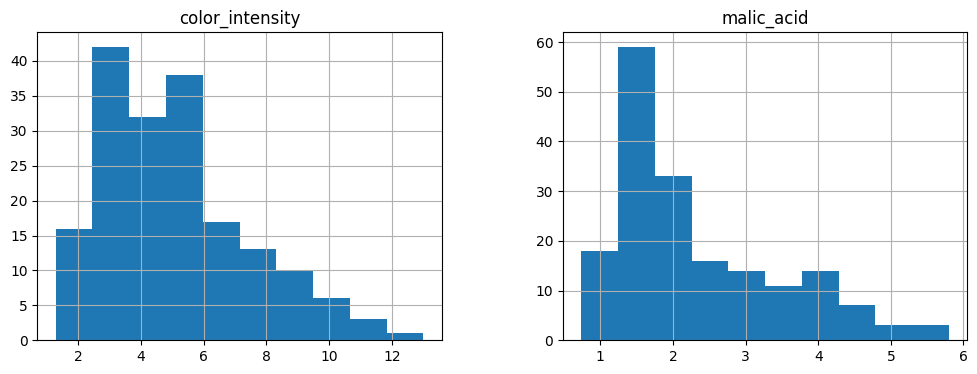

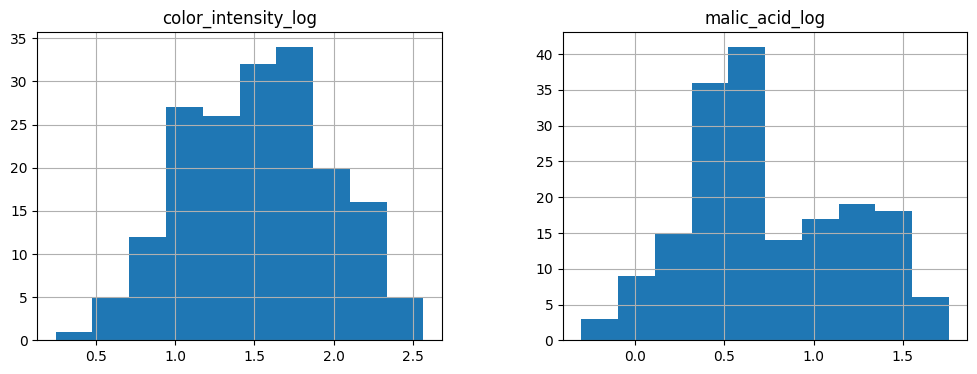

In [ ]:
# ライブラリの読み込み
from sklearn.datasets import load_wine

# データの読み込み
wine = load_wine()
df = pd.DataFrame(wine.data, columns=wine.feature_names)
df['variety'] = wine.target

# 対象変数の取り出し
cols = ['color_intensity', 'malic_acid']
X = df[cols]

# 元の分布の表示
X.hist(figsize=(12, 4))

# 対数変換
X_log = np.log(X)
cols_log = [s + '_log' for s in cols]
X_log.columns = cols_log

# 対数変換後の分布の表示
X_log.hist(figsize=(12, 4))
plt.show()

対数変換により、それぞれの分布の歪みが補正されていることがわかります。

これらを説明変数として、ロジスティック回帰の性能を比較してみましょう。
- 説明変数: `color_intensity`, `malic_acid`
- 目的変数: `variety` (ワインの種類, 3クラス)
- モデル: ロジスティック回帰
- 変数変換: 対数変換の有無
- 評価指標: F1スコア
- 検証方法: 5分割交差検証法

In [ ]:
# ライブラリの読み込み
from sklearn.model_selection import cross_val_score

# 目的変数の定義
target_variable = df['variety']

# ロジスティック回帰モデルの作成
logistic_model = LogisticRegression(random_state=42)

# モデルの学習とクロスバリデーションによる評価
# 対数変換を行わない場合
cv_score_without_log_transform = cross_val_score(logistic_model, X, target_variable, cv=5, scoring='f1_weighted').mean()

# 対数変換を行った場合
cv_score_with_log_transform = cross_val_score(logistic_model, X_log, target_variable, cv=5, scoring='f1_weighted').mean()

# 結果の表示
print('クロスバリデーションスコア (対数変換なし): {:.3f}'.format(cv_score_without_log_transform))
print('クロスバリデーションスコア (対数変換あり): {:.3f}'.format(cv_score_with_log_transform))

クロスバリデーションスコア (対数変換なし): 0.768
クロスバリデーションスコア (対数変換あり): 0.797


分布の歪んだ変数の対数変換により、ロジスティック回帰の性能が向上していることがわかります。

スケーリングで見たときと同様に、非決定木系のモデルは適切な非線形変換で性能を向上させます。

#### <練習問題 2>
今までに開催されたコンペティションのデータを用いて、数値変数の非線形変換の効果を検証してみましょう。

### 2.3 交差項の作成
数値変数に対する主要な特徴量エンジニアリング手法として、交差項の作成も挙げられます。
交差項とは、複数の変数を掛け合わせて新たに作成される変数を指します。

\begin{equation}
\text{例：}
(x_1, x_2, x_3) \rightarrow (x_1x_2, x_2x_3, x_3x_1)
\end{equation}

交差項を作成する際のデメリットは、変数が増えることで計算コストが大きくなることです。
そのため、後述の特徴選択などの変数を絞る手法と組み合わせて用いられることが多いです。

ここでは乳がんのデータセットの全ての変数を使って、交差項を作成してみます。

In [ ]:
import pandas as pd
from sklearn.datasets import load_breast_cancer

# データセットの読み込み
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)

# 元々の変数の数の確認
original_feature_count = X.shape[1]
print("元々の変数の数: {}".format(original_feature_count))
X.head()

元々の変数の数: 30


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


説明変数は30種類の数値変数から構成されていることがわかります。
これらから交差項を作成すると、${}_{30}\mathrm{C}_2+30 = 465$ 種類の変数に増えます。
このことを確認してみます。

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
# 交差項作成器の作成
pf = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)

# 交差項の作成
X_pf = pf.fit_transform(X)

# 変数の数の確認
interaction_feature_count = X_pf.shape[1]
print("交差項を含む変数の数: {}".format(interaction_feature_count))

# 交差項を含む新しいデータフレームを作成
X_pf_df = pd.DataFrame(X_pf, columns=pf.get_feature_names_out(input_features=X.columns))

# 結果の表示
X_pf_df.head()

交差項を含む変数の数: 465


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst compactness worst concavity,worst compactness worst concave points,worst compactness worst symmetry,worst compactness worst fractal dimension,worst concavity worst concave points,worst concavity worst symmetry,worst concavity worst fractal dimension,worst concave points worst symmetry,worst concave points worst fractal dimension,worst symmetry worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,0.473841,0.176650,0.306243,0.079140,0.188938,0.327545,0.084645,0.122111,0.031556,0.054706
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,0.045083,0.034708,0.051315,0.016611,0.044938,0.066440,0.021507,0.051150,0.016558,0.024481
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,0.191195,0.103153,0.153372,0.037178,0.109447,0.162730,0.039446,0.087796,0.021282,0.031643
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,0.595061,0.223072,0.575050,0.149870,0.176877,0.455964,0.118834,0.170928,0.044547,0.114837
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,0.082000,0.033313,0.048462,0.015740,0.065000,0.094560,0.030712,0.038415,0.012477,0.018151


#### <練習問題 3>
今までに開催されたコンペティションのデータを用いて、交差項を作成してみましょう。

## 3 カテゴリ変数のエンコーディング
初めに述べたように、カテゴリカル変数は予め数値変数に変換しておく必要がありました。
これをカテゴリカル変数のエンコーディングと言い、次のように様々な手法が存在します;
- Label Encoding
- Count Encoding
- Label-Count Encoding
- One-Hot Encoding（これらの他にも様々あります）

Titanicデータセットのカテゴリカル変数 `embarked`に対して、それぞれの適用方法を見てみましょう。
- `embarked`: 乗船した港、値は `C`, `Q`, `S` の三種類

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# データの読み込み（pathにはコンペティション1の対応するパスを入れてください）
path = "/content/drive/MyDrive/01.（公開）コンペ1/"

df = pd.read_csv(path + 'data/train.csv')

# 対象変数の取り出し
x = df['Embarked']

# 欠損値補完（最多の'S'で補完します）
x.fillna('S', inplace=True)

# 対象変数の確認
x.head(10)

,Embarked
0,S
1,C
2,S
3,S
4,S
5,Q
6,S
7,S
8,S
9,C


### 3.1 Label Encoding
Label Encodingでは、与えられたカテゴリカル変数に単純に数字を割り当てることでエンコーディングします。
　例: `C` → 0, `Q` → 1, `S` → 2

この手法の問題点は、3種類以上の値を含むカテゴリカル変数に対して、無意味な順序が導入されてしまうことです。
（例: CとQの差よりCとSの差の方が大きいということはないが、数値的にはそのようなことが含意されてしまう）

In [ ]:
# ライブラリの読み込み
from sklearn.preprocessing import LabelEncoder

# Label Encoding器の作成
le = LabelEncoder()

# Label Encodingの適用
x_le = le.fit_transform(x)

# 適用結果の確認（最初の10件）
x_le[:10]

array([2, 0, 2, 2, 2, 1, 2, 2, 2, 0])

### 3.2 Count Encoding
これに対してCount Encodingでは、与えられたカテゴリカル変数にそれぞれの値の出現回数を割り当てます。
　例: `C`, `Q`, `S`の出現回数がそれぞれ168, 77, 644であれば、`C` → 168, `Q` → 77, `S` → 644

この手法の問題点は、異なるカテゴリカル変数に同じ値が割り当てられ、情報が失われる場合があることです。
（例: `C`, `Q`の出現回数がそれぞれ1であれば、`C` → 1, `Q` → 1となり、同じ値になってしまう）

In [ ]:
# Count Encodingの適用
x_ce = x.map(x.value_counts())

# 適用結果の確認（最初の10件）
x_ce[:10]

,Embarked
0,646
1,168
2,646
3,646
4,646
5,77
6,646
7,646
8,646
9,168


### 3.3 Label-Count Encoding
Label-Count Encodingはその名の通り Label Encoding と Count Encoding を組み合わせたものです。
Label-Count Encodingでは、与えられたカテゴリカル変数にそれぞれの値の出現回数の順位を割り当てます。
　例: `C`, `Q`, `S`の出現回数がそれぞれ168(2位), 77(3位), 644(1位)であれば、`C` → 2, `Q` → 3, `S` → 1

Label-Count Encodingは、無意味な順序付けというLabel Encodingの問題点を解消する手法となっています。

また出現回数が同じ場合に順位を登場順に決めることにすれば（rankメソッドの引数をmethod='first'とする）
異なるカテゴリカル変数に対する値の衝突というCount Encodingの問題点も解消することができています。
（ただしこの場合、出現回数が同じカテゴリカル変数だけに対しては、無意味な順序が導入されてしまいます）

In [ ]:
# Label-Count Encodingの適用
x_lce = x.map(x.value_counts().rank(ascending=False, method='first'))

# 適用結果の確認（最初の10件）
x_lce[:10]

,Embarked
0,1.0
1,2.0
2,1.0
3,1.0
4,1.0
5,3.0
6,1.0
7,1.0
8,1.0
9,2.0


### 3.4 One-Hot Encoding
One-Hot Encodingは、カテゴリカル変数のそれぞれの値に対応するカラムを用意して、フラグを割り当てます。
この手法は、Label EncodingやCount Encodingで挙げられた問題点をいずれも解消することができています。

例:

|　index　|　Embarked　|　|→|　|　index　|　S　|　C　|　Q　|
|:-:|:-:|---|---|---|:-:|:-:|:-:|:-:|
|1 |S ||||1|1|0|0|
|2 |C ||||2|0|1|0|
|3 |S ||||3|1|0|0|
|4 |S ||||4|1|0|0|
|5 |S ||||5|1|0|0|
|6 |Q ||||6|0|0|1|

One-Hot Encodingの問題点は、カテゴリカル変数の値の種類だけカラム数が増え、疎になってしまうことです。
例えば1000種類の値をもつ変数に対してOne-Hot Encodingを適用すると、カラムが1000列増えてしまいます。
このような場合は、前述のLabel-Count Encodingなど他の手法を適用した方が良いということになるでしょう。

In [ ]:
# One-Hot Encodingの適用
x_ohe = pd.get_dummies(x)

# 適用結果の確認（最初の10件）
x_ohe[:10]

,C,Q,S
0,False,False,True
1,True,False,False
2,False,False,True
3,False,False,True
4,False,False,True
5,False,True,False
6,False,False,True
7,False,False,True
8,False,False,True
9,True,False,False


True/Falseのままでは動作しないモデルもあるので、0/1に変換します。

In [ ]:
x_ohe = x_ohe.astype(int)
x_ohe[:10]

,C,Q,S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1
5,0,1,0
6,0,0,1
7,0,0,1
8,0,0,1
9,1,0,0


### 3.5 特徴量の作成例
ここまでの方法を用いて、TitanicのデータにおけるNameカラムからMr.やMrs.などの敬称を取りだして特徴量として加えてみましょう。敬称は乗客の社会的地位や年齢層を示すためモデルの性能向上に役立つ可能性があります。まずデータを確認します。

In [ ]:
df.head()

,PassengerId,Perished,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,1,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


まず、敬称を抽出し、どのような名称があるのか確認します。

In [ ]:
import re
# 敬称を抽出する関数
def extract_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)# ' ([A-Za-z]+)\.' の正規表現パターンを用いて、名前から敬称を検索
    if title_search:
        return title_search.group(1)
    return ""

# 敬称の抽出
df['Title'] = df['Name'].apply(extract_title)

# 敬称のユニーク値を確認
df['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

見慣れない敬称も出てきました。それらがどんな頻度なのか確認します。

In [ ]:
title_counts = df['Title'].value_counts()
print(title_counts)

Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: count, dtype: int64


抽出した敬称をカテゴリー化します。

In [ ]:
# 一部の敬称を統合
df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace('Ms', 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')
# 頻度を再計算
title_counts = df['Title'].value_counts()
# 出現頻度が少ない敬称を「Rare」として統合
rare_titles = title_counts[title_counts < 10].index
df['Title'] = df['Title'].replace(rare_titles, 'Rare')

One-Hot Encodingにより、ダミー変数化してデータフレームに結合・格納します。

In [ ]:
# 敬称のダミー変数化
title_dummies = pd.get_dummies(df['Title'], prefix='Title')
# ダミー変数をTrue/Falseから0/1に変換
title_dummies = title_dummies.astype(int)

# データフレームにダミー変数を結合
df = pd.concat([df, title_dummies], axis=1)

# 不要なカラムの削除
df.drop(['Name', 'Title'], axis=1, inplace=True)

最後に特徴量が作成できたか確認してみます。

In [ ]:
df.head()

,PassengerId,Perished,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,1,1,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1,0,0
1,2,0,1,female,38.0,1,0,PC 17599,71.2833,C85,C,0,0,0,1,0
2,3,0,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,0,0,0
3,4,0,1,female,35.0,1,0,113803,53.1000,C123,S,0,0,0,1,0
4,5,1,3,male,35.0,0,0,373450,8.0500,NaN,S,0,0,1,0,0


無事、敬称を特徴量として扱うことができました。

#### <練習問題 4>
今までに開催されたコンペティションのデータを用いて、様々なエンコーディングを適用してみましょう。

## 4 時間変数のエンコーディング
時間や日付のように数値でも周期性をもつ変数は、その構造を反映した形でエンコードする必要があります。

まずは時系列データの取り扱いについて学習しましょう。

### 4.0 時系列データとは

キーワード：時間変化、数値、画像、音声、言語

まずは、時系列データとはどのようなデータであるのかについて理解しましょう。  

これまで扱ってきたテーブルデータは、個々のレコード（行）が個々の属性を持っており、それらが時間によって変化することは基本的にありません。  

対して、今回扱う時系列データとは、その名の通り**「時間に伴って変化するデータ」**のことです。

世の中には実に様々な時系列データが存在します。  

*   株価データ(時間に伴って数値が変化)
*   定期的に撮影した胃カメラのデータ(時間に伴って画像が変化)
*   工場現場の音声データ(時間に伴って音声が変化)
*   X(旧Twitter)のポスト(時間に伴って言語が変化)
*   etc...

と実に多様です。  
今回の講義では、１つの数値が時間に伴って変化する「単変量時系列データ」を主に扱います。  

以下の図で、これまで扱ってきたテーブルデータと単変量時系列データの違いを確認することができます。


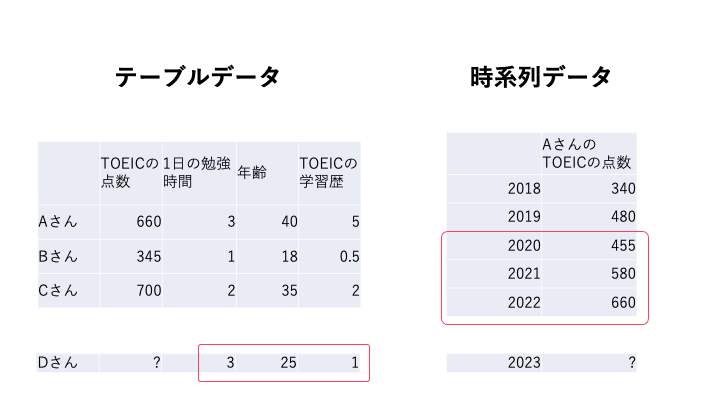

### 4.1 時系列データの取り扱い

ここでは、サンプルとして2010/1/1 0時から2014/12/31 23時までの北京でのpm2.5濃度の時系列データを扱います。

ここで利用するデータは以下のファイルです。

https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv

これをダウンロードし読み込みます。

In [ ]:
import requests
import io
# データがあるurlの指定
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv'

# データをurlから取得する
r = requests.get(url, stream=True).content
# データをDataFrameとして読み込む
Beijing_pm25=pd.read_csv(io.BytesIO(r))

今回は、読み込んだデータに含まれる2012年12月の北京でのpm2.5濃度のデータを使います。時間ごとの濃度データで、欠損している時間もあります。

`head`メソッドを使って、さきほど読み込んだBeijing_pm25の先頭5行を読み出します。

In [ ]:
Beijing_pm25.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


次に今回扱いたいデータである2012年12月の先頭5行を確認してみましょう。


In [ ]:
Beijing_pm25.loc[(Beijing_pm25['year']==2012)&(Beijing_pm25['month']==12)].head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
25560,25561,2012,12,1,0,41.0,-16,-8.0,1035.0,NW,1.79,0,0
25561,25562,2012,12,1,1,46.0,-17,-7.0,1035.0,cv,0.89,0,0
25562,25563,2012,12,1,2,37.0,-15,-7.0,1036.0,cv,1.34,0,0
25563,25564,2012,12,1,3,48.0,-15,-9.0,1035.0,NE,0.89,0,0
25564,25565,2012,12,1,4,43.0,-14,-9.0,1035.0,NE,1.78,0,0


サンプルには、様々なカラムや、5年分のデータがありますが、これをどう分析するかはそのニーズ次第です。例えば、今回のように2012年の12月のデータだけ欲しいこともありますし、月末の値だけを見たいこともあります。さらに、欠損値を直前の値で埋めたいこともありますし、前の日と比べてどれだけ値が上がったのか調べたい場合もあるでしょう。これらのことはすべてPandasで簡単に計算することができます。

最初に、今回扱いたいデータは、2012年の12月のpm2.5濃度だけなのでデータを扱いやすいように整形します。

まず、year、month、day、hourの4つのカラムに分かれている時刻のデータを扱いやすいdatetime型のカラム1つにまとめ、このカラムをindexとし、今回扱いたいpm2.5濃度のカラムのみで構成されたDataFrameとしてpm25を作成します。

In [ ]:
pm25 = pd.DataFrame(Beijing_pm25['pm2.5'].values,index = pd.to_datetime(Beijing_pm25[['year','month','day','hour']]),columns=['pm2.5'])

もういちど`head`メソッドを使い確認してみましょう。


In [ ]:
pm25.head()

,pm2.5
2010-01-01 00:00:00,NaN
2010-01-01 01:00:00,NaN
2010-01-01 02:00:00,NaN
2010-01-01 03:00:00,NaN
2010-01-01 04:00:00,NaN


このままだと表示されている部分がすべて欠損しているため正しくデータが整形できたかわからないので、2012年12月のデータを参照して確認してみましょう。


#### 特定の年月のデータを参照する

特定の年月のデータを参照する方法です。2012年12月のデータだけ見たい場合は、以下のように年月日を指定します。

In [ ]:
pm25.loc['2012']

,pm2.5
2012-01-01 00:00:00,275.0
2012-01-01 01:00:00,303.0
2012-01-01 02:00:00,215.0
2012-01-01 03:00:00,222.0
2012-01-01 04:00:00,85.0
...,...
2012-12-31 19:00:00,104.0
2012-12-31 20:00:00,131.0
2012-12-31 21:00:00,113.0
2012-12-31 22:00:00,45.0


今回扱いたいデータはこの2012年12月のデータのみなので、新たにpm25_12_12というDataFrameを作成します。

In [ ]:
pm25_12_12 = pm25.loc['2012-12']
pm25_12_12.head()

,pm2.5
2012-12-01 00:00:00,41.0
2012-12-01 01:00:00,46.0
2012-12-01 02:00:00,37.0
2012-12-01 03:00:00,48.0
2012-12-01 04:00:00,43.0


そのほか、特定の年や日にちにだけ抽出することもできます。
次に、日ごとの最終濃度だけ取り出してみましょう。`resample`メソッドの引数に`D`を指定することで、日ごとのデータを取り出し、`last`メソッドで末尾のデータを取り出しています。具体的には、以下の結果をみるとわかる通り、1日、2日、3日…の23時の濃度を取り出せます。

In [ ]:
pm25_12_12.resample('D').last().head()

,pm2.5
2012-12-01,119.0
2012-12-02,313.0
2012-12-03,40.0
2012-12-04,39.0
2012-12-05,29.0


月を取り出したい場合は「`M`」、年を取り出したい場合は「`Y`」を、それぞれ引数に指定します。このように、ある頻度のデータを、別の頻度のデータで取り出し直す処理を**リサンプリング**といいます。また、最後のデータではなく、その平均を計算したい場合は`mean`メソッドを使うことで計算できます。他にもいろいろとパラメータを設定できるので、必要な処理があるときに、調べてみてください。

数値で保持されている時系列データは、プロットすることでデータ理解が大幅に捗ります。早速プロットしてみましょう。

<Figure size 1000x500 with 0 Axes>

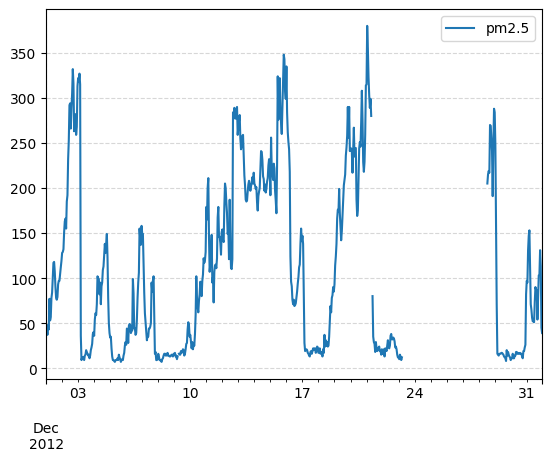

In [ ]:
# インデックスを日付型に変換（必要に応じて）
pm25_12_12.index = pd.to_datetime(pm25_12_12.index)

# グラフの大きさを調整
plt.figure(figsize=(10, 5))

# データをプロット
pm25_12_12.plot()

# グリッド線を追加
plt.grid(True, linestyle='--', alpha=0.5)

# グラフを表示
plt.show()


グラフにすると、データのあり方がより詳しく確認できます。まずは月末にデータが欠損している個所がよく確認できます。また、濃度が高い時期が数日続いた後、急に減少するパターンなど、可視化することによって様々な特徴が見えてきます。

#### 欠損がある場合の操作

時系列データに欠損がある場合の処理をみていきます。欠損処理については、さまざまな方法があります。
ここでは、1日の最後の測定値を用い、31日分のデータについて様々な処理を行っていきます。日ごとにデータを用意したいときは、先ほどのリサンプリングを行います。具体的には、以下のようにします。

In [ ]:
pm25_12_12.resample('D').last().head(31)

,pm2.5
2012-12-01,119.0
2012-12-02,313.0
2012-12-03,40.0
2012-12-04,39.0
2012-12-05,29.0
2012-12-06,158.0
2012-12-07,10.0
2012-12-08,16.0
2012-12-09,35.0
2012-12-10,129.0


上記より、2012/12/24～2012/12/27は欠損しているので、前の日の値で埋める処理をします。ここでは、次に示すようにffillメソッドを使います。



In [ ]:
pm25_12_12.resample('D').last().ffill().head(31)

,pm2.5
2012-12-01,119.0
2012-12-02,313.0
2012-12-03,40.0
2012-12-04,39.0
2012-12-05,29.0
2012-12-06,158.0
2012-12-07,10.0
2012-12-08,16.0
2012-12-09,35.0
2012-12-10,129.0


#### データをズラして比率を計算する

次に、前の値と比較をしたい場合を考えます。今回のデータでいうと、2012-12-01 の23時の濃度は119.0で、2012-12-02の23時の濃度は313.0になり、その比率を計算することもできますが、それをすべての日付について適応させる処理をします。shiftメソッドを使うことで、インデックスは固定したまま、そのデータだけをずらすことができます。以下はデータを1つあとにずらしており、2012-12-01の23時の濃度は119.0でしたが、2012-12-02の23時の濃度として扱われるようになります。

In [ ]:
pm25_12_12.resample('D').last().shift(1).head()

,pm2.5
2012-12-01,NaN
2012-12-02,119.0
2012-12-03,313.0
2012-12-04,40.0
2012-12-05,39.0


このように加工すると、前日の濃度と当日の濃度の比率を一気に算出することができます。これがPandasを使うメリットです。なお、以下で2012-12-01が`NaN`になっているのは、その前日のデータがもともとないためです。

In [ ]:
pm25_ratio = pm25_12_12.resample('D').last() / pm25_12_12.resample('D').last().shift(1)
pm25_ratio.head()

,pm2.5
2012-12-01,NaN
2012-12-02,2.630252
2012-12-03,0.127796
2012-12-04,0.975000
2012-12-05,0.743590


なお、差分や比率を取る方法については、`diff`や`pct_change`などもありますので、興味がある方は調べてみてください。

#### <練習問題 5>

上記のようにして作成したDataFrame、pm25を使って、年ごとの平均値の推移データを作成してください。

In [ ]:
# write me!

####  移動平均
次に、時系列のデータ処理でよく使われる移動平均の処理方法をみていきます。さきほど扱った`PM2.5`のデータについて、3時間の移動平均線を作成することを考えます。まず先頭から5行のデータを取り出してみます。

In [ ]:
pm25_12_12.head()

,pm2.5
2012-12-01 00:00:00,41.0
2012-12-01 01:00:00,46.0
2012-12-01 02:00:00,37.0
2012-12-01 03:00:00,48.0
2012-12-01 04:00:00,43.0


結果を見るとわかるように、2012-12-01 2時までのデータは、0時が41.0、1時が46.0、2時が37.0ですから、その平均を計算すると41.333です。同様にして、3時、4時と続けて計算をしていきます。それにはPpandasの`rolling`メソッドを使うと、簡単に計算できます。以下は、その3時間の移動平均を計算した結果です。`rolling`メソッドを実行した後に、`mean`メソッドを使って平均を計算しています。

In [ ]:
pm25_12_12.rolling(3).mean().head()

,pm2.5
2012-12-01 00:00:00,NaN
2012-12-01 01:00:00,NaN
2012-12-01 02:00:00,41.333333
2012-12-01 03:00:00,43.666667
2012-12-01 04:00:00,42.666667


移動平均ではなく標準偏差の推移を算出したいのなら、`mean`メソッドの代わりに`std`メソッドを使います。以下は3時間の標準偏差の推移です。

In [ ]:
pm25_12_12.rolling(3).std().head()

,pm2.5
2012-12-01 00:00:00,NaN
2012-12-01 01:00:00,NaN
2012-12-01 02:00:00,4.509250
2012-12-01 03:00:00,5.859465
2012-12-01 04:00:00,5.507571


`rolling`メソッドには、パラメータが他にもいろいろとありますので、必要に応じて調べて実行してみてください。

#### <練習問題 6>

<練習問題 5>で使用したpm25を使って、20日間の移動平均データを作成してください。ただし`NaN`は削除してください。なお、レコードとして存在しないデータであれば、特に補填する必要はありません。

In [ ]:
# write me!

### 4.2 周期性を考慮しないエンコーディング
ここまで時系列データの見方について取り扱ってきました。ここでは、時系列性を持った特徴量をどのように扱うのか勉強します。まずは周期性を考慮しないエンコーディング手法をいくつか見てみましょう。

最も単純なエンコーディング手法は年月日それぞれを数値変数とする方法です。


ここでは日付を例にとって、時間変数のエンコーディング手法を見ていきましょう。

まずここで扱うサンプルデータとして、2010年代の日付をランダムに10個取得します。

In [ ]:
import datetime
import random

# startとendの間のランダムな日付を出力する関数
def generate_rand_date(start, end):
    days_delta = (end - start).days
    return start + datetime.timedelta(days=random.randint(0, days_delta))

# 乱数シードを固定して、2010年代の日付をランダムに10個取得
random.seed(0)
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2020, 12, 31)
random_dates = [generate_rand_date(start, end) for _ in range(10)]

# 日付データをDataFrame化
df_dates = DataFrame(random_dates, columns=['ymd'])
df_dates

,ymd
0,2019-06-21
1,2014-04-27
2,2018-07-02
3,2019-12-26
4,2014-09-19
5,2010-06-15
6,2012-11-26
7,2020-10-29
8,2015-09-26
9,2015-06-14


In [ ]:
# 年月日を、年・月・日に分割
df_dates['year'] = df_dates['ymd'].apply(lambda x: x.year)
df_dates['month'] = df_dates['ymd'].apply(lambda x: x.month)
df_dates['day'] = df_dates['ymd'].apply(lambda x: x.day)

df_dates

,ymd,year,month,day
0,2019-06-21,2019,6,21
1,2014-04-27,2014,4,27
2,2018-07-02,2018,7,2
3,2019-12-26,2019,12,26
4,2014-09-19,2014,9,19
5,2010-06-15,2010,6,15
6,2012-11-26,2012,11,26
7,2020-10-29,2020,10,29
8,2015-09-26,2015,9,26
9,2015-06-14,2015,6,14


このようにすることで、年月日それぞれを数値変数として扱うことができるようになりました。
しかしこのような手法に対しては以下のように、大きく二つの問題点を挙げることができます。
1. 年・月・日の情報がバラバラであり時系列的な新旧の学習が困難
(例: 2010年1月1日と2020年1月1日が時系列的に離れているということを表現できていない)
2. 時系列として連続的であるべき部分に断絶が生じてしまっている
(例: 1月と12月、1日と31日がそれぞれ周期的な意味で近いということを表現できていない)

前者に対処するためには、基準時点との差分を新たな変数とする手法を用いることができます。
このようにエンコードすることで、日付の新旧という情報を表すことができるようになります。
今回は日付を扱っているので2010年1月1日を基準日とし、差分を新たな変数としてみましょう。

In [ ]:
# 基準日を2010年1月1日に設定
start_date = pd.Timestamp('2010-01-01 00:00:00')

# 基準日との差分を格納
df_dates['total_days'] = df_dates['ymd'].apply(lambda x: (x - start_date).days)

df_dates

,ymd,year,month,day,total_days
0,2019-06-21,2019,6,21,3458
1,2014-04-27,2014,4,27,1577
2,2018-07-02,2018,7,2,3104
3,2019-12-26,2019,12,26,3646
4,2014-09-19,2014,9,19,1722
5,2010-06-15,2010,6,15,165
6,2012-11-26,2012,11,26,1060
7,2020-10-29,2020,10,29,3954
8,2015-09-26,2015,9,26,2094
9,2015-06-14,2015,6,14,1990


このようにすることで、時系列的な新旧の情報を明示的にエンコードすることができました。
次に周期性を考慮したエンコーディング手法も用いることで、後者の問題に対処しましょう。

### 4.3 周期性を考慮したエンコーディング
時間変数の周期的な構造をエンコードするためには、三角関数を用いることができます。
月や日といった周期性をもつものを単位円周上の点に対応づけて、各点の座標で表します。
このとき各点の座標は$\cosと\sin$で表されるので、これらを新たな数値変数として用います。

In [ ]:
df_dates['month_cos'] = df_dates['month'].apply(lambda x: np.cos(2*np.pi * x/12))
df_dates['month_sin'] = df_dates['month'].apply(lambda x: np.sin(2*np.pi * x/12))

df_dates['day_cos'] = df_dates['day'].apply(lambda x: np.cos(2*np.pi * x/31))
df_dates['day_sin'] = df_dates['day'].apply(lambda x: np.sin(2*np.pi * x/31))

df_dates

,ymd,year,month,day,total_days,month_cos,month_sin,day_cos,day_sin
0,2019-06-21,2019,6,21,3458,-1.000000e+00,1.224647e-16,-0.440394,-0.897805
1,2014-04-27,2014,4,27,1577,-5.000000e-01,8.660254e-01,0.688967,-0.724793
2,2018-07-02,2018,7,2,3104,-8.660254e-01,-5.000000e-01,0.918958,0.394356
3,2019-12-26,2019,12,26,3646,1.000000e+00,-2.449294e-16,0.528964,-0.848644
4,2014-09-19,2014,9,19,1722,-1.836970e-16,-1.000000e+00,-0.758758,-0.651372
5,2010-06-15,2010,6,15,165,-1.000000e+00,1.224647e-16,-0.994869,0.101168
6,2012-11-26,2012,11,26,1060,8.660254e-01,-5.000000e-01,0.528964,-0.848644
7,2020-10-29,2020,10,29,3954,5.000000e-01,-8.660254e-01,0.918958,-0.394356
8,2015-09-26,2015,9,26,2094,-1.836970e-16,-1.000000e+00,0.528964,-0.848644
9,2015-06-14,2015,6,14,1990,-1.000000e+00,1.224647e-16,-0.954139,0.299363


このようにすることで、周期的な構造を踏まえて時間変数をエンコードすることができました。

## 5 次元削減と特徴選択
元々の説明変数が多かったり、特徴量エンジニアリングで変数が増えたりすると、計算コストが大きくなります。
このように計算コストが問題となったりモデルの説明性が求められるような場合、変数を減らす必要があります。
変数を減らす手法には、次元削減と特徴選択があります。ここでは、そのそれぞれの代表的な手法を紹介します。

### 5.1 次元削減（教師なし学習で勉強してからまた復習してください。）
教師なし学習の章で学ぶPCA（主成分分析）は、説明変数の次元削減に応用することができます。
PCAを用いた次元削減は、次のように実行できます。

1. 変数をスケーリングする
2. PCAを施す
3. 寄与率などを参考に変換後の変数を絞る

ここでは乳がんデータセットを用い、PCAによりデータの次元を元の30次元から削減してみます。
ただしPCAを適用した後の変数は、累積寄与率がおおよそ80%となるように次元削減を行います。

In [ ]:
# ライブラリの読み込み
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA

# データの読み込み
cancer = load_breast_cancer()
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df['target'] = cancer.target

# 説明変数の取り出し
X = df.iloc[:, :-1]
y = df['target']
# スケーリング
ss = StandardScaler()
X_std = ss.fit_transform(X)

# PCAの適用
pca = PCA()
X_pca = pca.fit_transform(X_std)

# 累積寄与率の確認
ev_ratio = pca.explained_variance_ratio_
ev_ratio = ev_ratio.cumsum().round(3)
ev_ratio

array([0.443, 0.632, 0.726, 0.792, 0.847, 0.888, 0.91 , 0.926, 0.94 ,
       0.952, 0.961, 0.97 , 0.978, 0.983, 0.986, 0.989, 0.991, 0.993,
       0.995, 0.996, 0.997, 0.997, 0.998, 0.999, 0.999, 1.   , 1.   ,
       1.   , 1.   , 1.   ])

この結果から第5主成分までを採用すれば、累積寄与率がおよそ0.8となることがわかります。
つまりこの累積寄与率0.8の基準であれば、次元を元の30次元から5次元まで削減できました。

累積寄与率を可視化してみます。

累積寄与率が0.8を超えるために必要な主成分数: 5


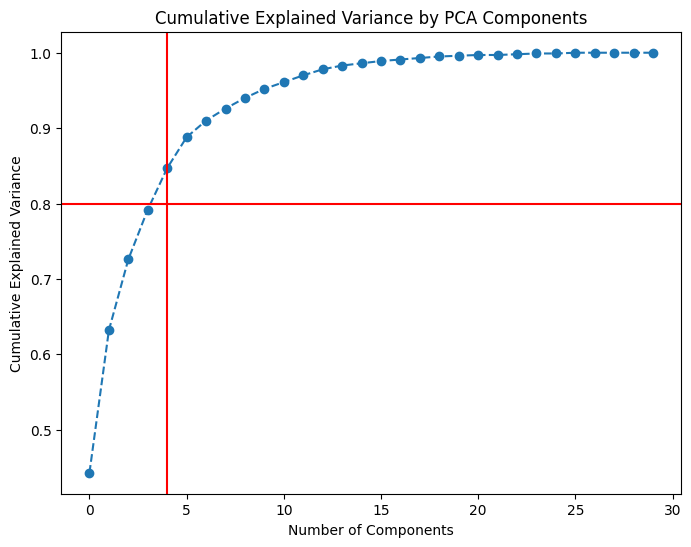

In [ ]:
# 累積寄与率が0.8を超える主成分数を取得
n_components = (ev_ratio < 0.8).sum() + 1
print(f"累積寄与率が0.8を超えるために必要な主成分数: {n_components}")

# 必要な主成分数を使用してPCAを再適用　次のセルで使います
pca = PCA(n_components=n_components)
X_reduced = pca.fit_transform(X_std)

# 累積寄与率のプロット
plt.figure(figsize=(8, 6))
plt.plot(ev_ratio, marker='o', linestyle='--')
plt.axhline(y=0.8, color='r', linestyle='-')
plt.axvline(x=n_components-1, color='r', linestyle='-')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()


ついでに、第1主成分と第2主成分を用いてデータを二次元平面上にプロットしてみましょう。今回の場合は、この二成分だけで赤色と青色のデータポイント（目的変数の違い）がある程度分離していることがわかります。

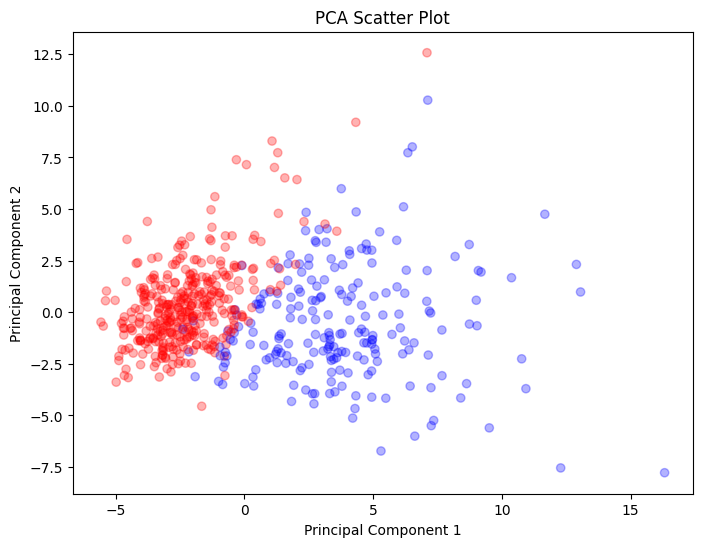

In [ ]:
# 散布図を表示
plt.figure(figsize=(8, 6))
color_list = list(map(lambda x: ['b', 'r'][x], y))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], alpha=0.3, color=color_list)
plt.title('PCA Scatter Plot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

#### <練習問題 7>
元のデータで学習させたモデルの性能と、PCAで次元削減したモデルの性能を比較してみましょう。

#### <練習問題 8>
今までに開催されたコンペティションのデータに対して、PCAによる次元削減を行ってみましょう。

### 5.2 特徴選択
PCAによる次元削減では変数を主成分に変換した上で、寄与率に基づいて絞り込みました。
一方、特徴選択では、変数をそのままに、回帰係数や変数重要度に基づいて絞り込みます。
そのため、特徴選択では回帰係数や変数重要度を出力できるモデルを与える必要があります。
- 回帰: ランダムフォレスト回帰、リッジ回帰 etc.
- 分類: ランダムフォレスト分類、ロジスティック回帰 etc.

ここでは2.3の交差項の作成で大量に作成されてしまった変数を10個に絞り込みましょう。 設定するモデルは、変数重要度の出力が可能であるランダムフォレスト回帰モデルとします。

まず、もう一度データセットから交差項を作成します。

In [ ]:
# データセットの読み込み
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target  # 目的変数
# 元々の変数の数の確認
original_feature_count = X.shape[1]
print("元々の変数の数: {}".format(original_feature_count))

# 交差項作成器の作成
pf = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)

# 交差項の作成
X_pf = pf.fit_transform(X)

# 変数の数の確認
interaction_feature_count = X_pf.shape[1]
print("交差項を含む変数の数: {}".format(interaction_feature_count))

# 交差項を含む新しいデータフレームを作成
X_pf_df = pd.DataFrame(X_pf, columns=pf.get_feature_names_out(input_features=X.columns))
X_pf_df.head()


元々の変数の数: 30
交差項を含む変数の数: 465


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst compactness worst concavity,worst compactness worst concave points,worst compactness worst symmetry,worst compactness worst fractal dimension,worst concavity worst concave points,worst concavity worst symmetry,worst concavity worst fractal dimension,worst concave points worst symmetry,worst concave points worst fractal dimension,worst symmetry worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,0.473841,0.176650,0.306243,0.079140,0.188938,0.327545,0.084645,0.122111,0.031556,0.054706
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,0.045083,0.034708,0.051315,0.016611,0.044938,0.066440,0.021507,0.051150,0.016558,0.024481
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,0.191195,0.103153,0.153372,0.037178,0.109447,0.162730,0.039446,0.087796,0.021282,0.031643
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,0.595061,0.223072,0.575050,0.149870,0.176877,0.455964,0.118834,0.170928,0.044547,0.114837
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,0.082000,0.033313,0.048462,0.015740,0.065000,0.094560,0.030712,0.038415,0.012477,0.018151


交差項が増えたことを確認しました。それでは特徴選択を行い、変数を10個に削減します。

どのような手順で行うかを確認するために、ここでは、もともとの特徴量30個だけで行ったものを示します。挙動を確認するにはこれで構いません。


講義中は、実際に交差項を含むもので検証したものを解説します。（実行に20分以上かかるので、もし実行される場合は気を付けてください。）

In [ ]:
#挙動検証用　実行の確認にはこちらで問題ないです。

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

# 特徴選択器の作成
rfr = RandomForestRegressor(random_state=42)
rfe = RFE(estimator=rfr, n_features_to_select=10)

# 交差項を含むケースで特徴選択の実行と選択された特徴量のデータフレームを作成
# rfe.fit(X_pf_df, y)  # 全特徴量を使用する場合
# X_rfe = X_pf_df.loc[:, rfe.support_]

# 上は時間がかかるので元の特徴量だけで特徴選択の実行と選択された特徴量のデータフレームを作成
rfe.fit(X, y)  # 元の特徴量だけで検証する場合
X_rfe = X.loc[:, rfe.support_]

# 選択された特徴量の数の確認
print("選択された特徴量の数: {}".format(X_rfe.shape[1]))

# 選択された特徴量の表示
X_rfe.head()

選択された特徴量の数: 10


,mean texture,mean concave points,area error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst concavity,worst concave points
0,10.38,0.14710,153.40,25.38,17.33,184.60,2019.0,0.1622,0.7119,0.2654
1,17.77,0.07017,74.08,24.99,23.41,158.80,1956.0,0.1238,0.2416,0.1860
2,21.25,0.12790,94.03,23.57,25.53,152.50,1709.0,0.1444,0.4504,0.2430
3,20.38,0.10520,27.23,14.91,26.50,98.87,567.7,0.2098,0.6869,0.2575
4,14.34,0.10430,94.44,22.54,16.67,152.20,1575.0,0.1374,0.4000,0.1625


このようにして特徴量を30個から10個に絞ることができました。この特徴選択は特徴量重要度の順で選択しています。特徴選択を行わない場合と比較して、重要度の高い10個の特徴量を可視化してみます。

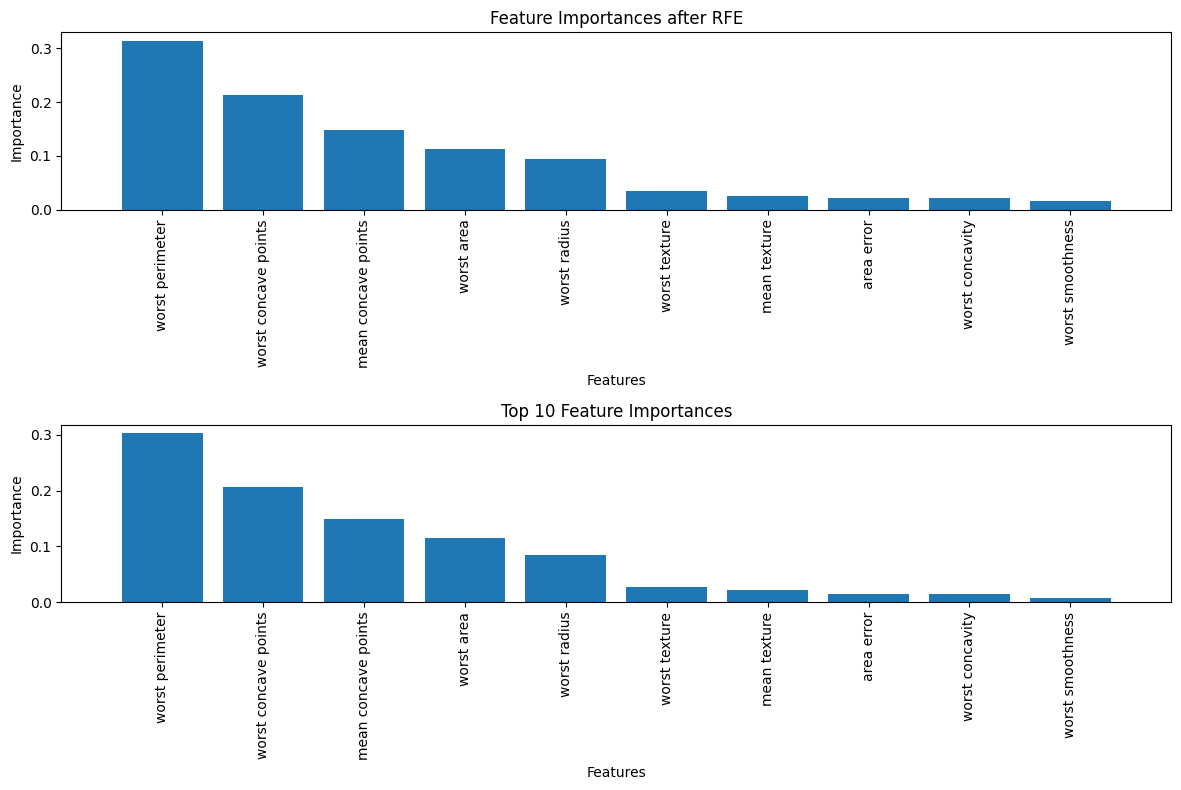

In [ ]:
# 選択された特徴量の重要度を取得
selected_importances = rfe.estimator_.feature_importances_

# 選択された特徴量名を取得
selected_features = X_rfe.columns

# すべての特徴量の重要度を取得
all_importances = RandomForestRegressor(random_state=42).fit(X, y).feature_importances_

# すべての特徴量の名前を取得
all_features = X.columns

# 選択された特徴量の重要度と特徴量名を並べ替え
sorted_indices = np.argsort(selected_importances)[::-1]
sorted_selected_importances = selected_importances[sorted_indices]
sorted_selected_features = selected_features[sorted_indices]

# 特徴量重要度の比較プロット
plt.figure(figsize=(12, 8))

# 選択された特徴量の重要度のプロット
plt.subplot(2, 1, 1)
plt.title("Feature Importances after RFE")
plt.bar(range(len(sorted_selected_importances)), sorted_selected_importances, align="center")
plt.xticks(range(len(sorted_selected_importances)), sorted_selected_features, rotation=90)
plt.xlim([-1, len(sorted_selected_importances)])
plt.xlabel('Features')
plt.ylabel('Importance')

# すべての特徴量の重要度のプロット（上位10個）
indices = np.argsort(all_importances)[::-1][:10]
plt.subplot(2, 1, 2)
plt.title("Top 10 Feature Importances")
plt.bar(range(len(indices)), all_importances[indices], align="center")
plt.xticks(range(len(indices)), np.array(all_features)[indices], rotation=90)
plt.xlim([-1, len(indices)])
plt.xlabel('Features')
plt.ylabel('Importance')

plt.tight_layout()
plt.show()

以下には、講義で扱う交差項を含むもので検証した結果を示しておきます。実際に実行される場合はコメントアウトを変更してください。なお、流れは上と全く同じなので実行しなくても問題ないです。

In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.feature_selection import RFE

# # 特徴選択器の作成
# rfr = RandomForestRegressor(random_state=42)
# rfe = RFE(estimator=rfr, n_features_to_select=10)

# # 交差項を含むケースで特徴選択の実行と選択された特徴量のデータフレームを作成
# rfe.fit(X_pf_df, y)  # 全特徴量を使用する場合
# X_rfe = X_pf_df.loc[:, rfe.support_]

# # 選択された特徴量の数の確認
# print("選択された特徴量の数: {}".format(X_rfe.shape[1]))

# # 選択された特徴量の表示
# X_rfe.head()

選択された特徴量の数: 10


,mean texture mean area,mean concavity worst area,mean concave points worst texture,worst texture worst area,worst texture worst concave points,worst perimeter worst smoothness,worst area worst smoothness,worst area worst concavity,worst area worst concave points,worst area worst symmetry
0,10390.380,605.90190,2.549243,34989.27,4.599382,29.942120,327.48180,1437.32610,535.84260,928.94190
1,23563.020,169.97640,1.642680,45789.96,4.354260,19.659440,242.15280,472.56960,363.81600,537.90000
2,25563.750,337.35660,3.265287,43630.77,6.203790,22.021000,246.77960,769.73360,415.28700,617.46170
3,7868.718,137.04278,2.787800,15044.05,6.823750,20.742926,119.10346,389.95313,146.18275,376.83926
4,18598.980,311.85000,1.738681,26255.25,2.708875,20.912280,216.40500,630.00000,255.93750,372.33000


以下に交差項を含むもので実行した場合のものを可視化しておきます。同様に、特徴量重要度の高いものの特徴量が変わっていることがわかります。

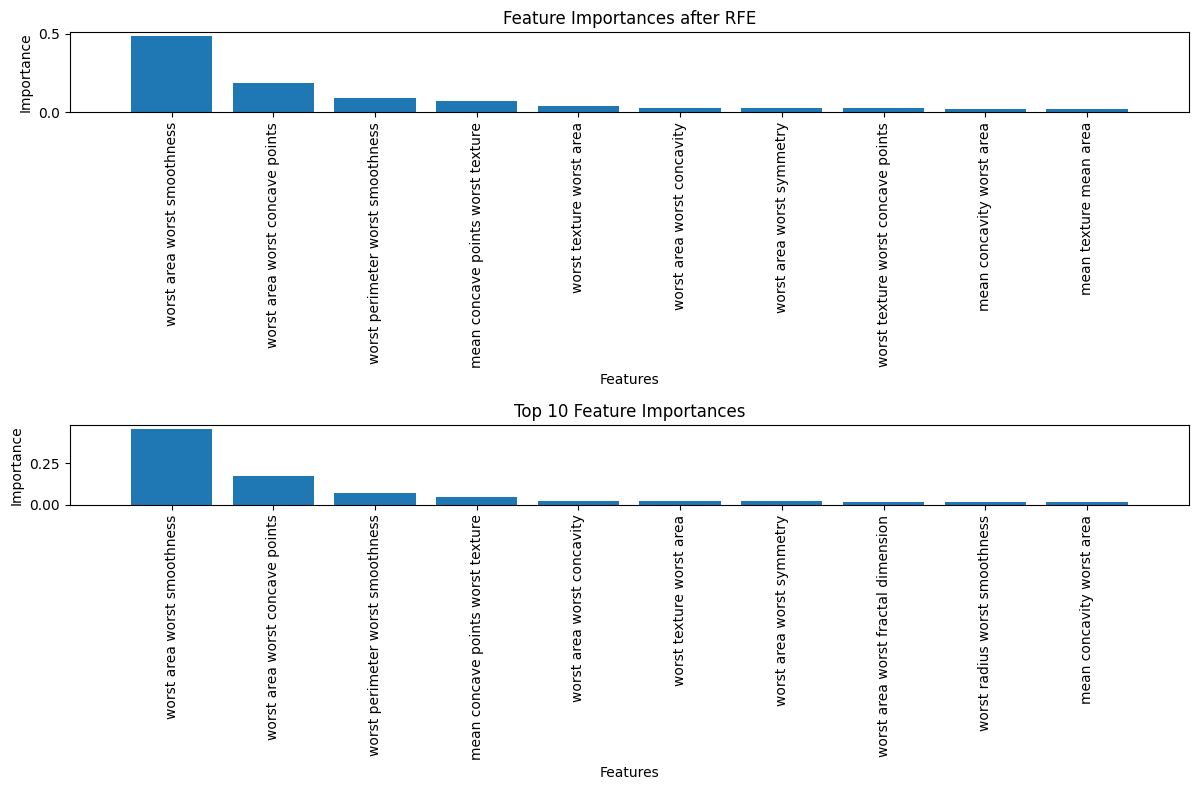

In [ ]:
# # 選択された特徴量の重要度を取得
# selected_importances = rfe.estimator_.feature_importances_

# # 選択された特徴量名を取得
# selected_features = X_rfe.columns

# # すべての特徴量の重要度を取得
# all_importances = RandomForestRegressor(random_state=42).fit(X_pf_df, y).feature_importances_

# # すべての特徴量の名前を取得
# all_features = X_pf_df.columns

# # 選択された特徴量の重要度と特徴量名を並べ替え
# sorted_indices = np.argsort(selected_importances)[::-1]
# sorted_selected_importances = selected_importances[sorted_indices]
# sorted_selected_features = selected_features[sorted_indices]

# # 特徴量重要度の比較プロット
# plt.figure(figsize=(12, 8))

# # 選択された特徴量の重要度のプロット
# plt.subplot(2, 1, 1)
# plt.title("Feature Importances after RFE")
# plt.bar(range(len(sorted_selected_importances)), sorted_selected_importances, align="center")
# plt.xticks(range(len(sorted_selected_importances)), sorted_selected_features, rotation=90)
# plt.xlim([-1, len(sorted_selected_importances)])
# plt.xlabel('Features')
# plt.ylabel('Importance')

# # すべての特徴量の重要度のプロット（上位10個）
# indices = np.argsort(all_importances)[::-1][:10]
# plt.subplot(2, 1, 2)
# plt.title("Top 10 Feature Importances")
# plt.bar(range(len(indices)), all_importances[indices], align="center")
# plt.xticks(range(len(indices)), np.array(all_features)[indices], rotation=90)
# plt.xlim([-1, len(indices)])
# plt.xlabel('Features')
# plt.ylabel('Importance')

# plt.tight_layout()
# plt.show()

このようにして、465種類あった変数を10種類まで選択することができました。

また、再帰的に特徴量を選択することで、最も重要な特徴量を見つけ出す手法なので、元のデータセット内における特徴量重要度と変わっている部分もあることがわかりました。この手法は計算コストが高いので、先に紹介した次元削減などと組み合わせるとよいかもしれません。

#### <練習問題 9>
元データ・交差項追加データ・特徴選択データそれぞれで、モデルの性能と学習時間を比較してみましょう。

#### <練習問題 10>
今までに開催されたコンペティションのデータに対して、特徴選択を行ってみましょう。